In [34]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from matplotlib import pyplot
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
import re
import joblib

In [35]:
import warnings
warnings.filterwarnings('ignore')

In [36]:
train = pd.read_csv("train_df.csv")
test = pd.read_csv("test_df.csv")
ts_df = pd.read_csv('ts_pred.csv')

In [37]:
pred_date = pd.date_range(start='2021-10-16', end='2021-11-05', freq='1D')
pred_date = pred_date.strftime('%Y-%m-%d').tolist()

forecast_date = pd.date_range(start='2021-11-06', end='2021-12-03', freq='1D')
forecast_date = forecast_date.strftime('%Y-%m-%d').tolist()

pred_forecast_date = pred_date + forecast_date

state_list = ts_df.subregion1_code.unique().tolist()

predictors = ' '.join(train.columns)
mob_predictors = re.findall(r'mobility_\w+', predictors)
searchtrend_predictors = re.findall(r'search_trends_\w+', predictors)
ts_predictors = mob_predictors + searchtrend_predictors

In [38]:
static_latest_raw = pd.DataFrame()
for state in state_list:
    find_df = test[test['subregion1_code'] == state]
    find_df['date'] = pd.to_datetime(find_df['date'])
    date_latest = find_df['date'].max()
    state_row = find_df[find_df['date'] == date_latest]
    static_latest_raw = static_latest_raw.append(state_row)
    
nj_latest = train[(train['subregion1_code']=='NJ')&(train['date']=='2021-10-04')]
static_latest_raw = static_latest_raw.append(nj_latest)

static_latest = static_latest_raw.drop(["date"]+["cumulative_confirmed"]+ts_predictors, axis = 1)
static_latest = static_latest.reset_index(drop = True)

static_df = pd.DataFrame(np.repeat(static_latest.values, len(pred_forecast_date), axis=0))
static_df.columns = static_latest.columns

static_df = static_df.sort_values(by=['subregion1_code'])

static_df = static_df.reset_index(drop = True)
static_df['date'] = pred_forecast_date * len(state_list)

In [39]:
pred_df = pd.merge(ts_df, static_df, on = ['subregion1_code', 'date'])

pred_df['date'] =pd.to_datetime(pred_df['date'])
pred_df = pred_df.sort_values(by=['subregion1_code', 'date'])
pred_df = pred_df.drop(['type'], axis = 1)

In [41]:
loaded_gbm = joblib.load("GBM_fin.joblib")

In [56]:
gbm_init = joblib.load("GBM_untuned.joblib")

In [75]:
res_df_gbm = pd.DataFrame()
#for state in static_latest.subregion1_code.unique():
for state in state_list:
    state_col = [state] * (len(pred_date)+len(forecast_date))
    pred_type = ['prediction'] * (len(pred_date))+ ['forecast'] *len(forecast_date)
    pred_curr = pd.DataFrame(list(zip(state_col, pred_date + forecast_date, pred_type)),
                          columns =['subregion1_code', 'date', 'type'])
    

    s_test = pred_df[pred_df["subregion1_code"]==state]
    
    
    s_test = s_test.drop(["date","subregion1_code"], axis = 1)
    s_X_test = s_test.drop(["new_confirmed"], axis = 1)
    
    s_X_test = s_X_test.apply(pd.to_numeric, errors='coerce', axis=1)
    
   
    s_y_pred_new = loaded_gbm.predict(s_X_test)
    
    pred_curr['new_confirmed_pred'] = s_y_pred_new
    
    #create prediction dataframe
    res_df_gbm = res_df_gbm.append(pred_curr)

In [77]:
res_df_gbm.to_csv('res_gbm_tuned.csv', index = False)

In [76]:
res_df_gbm

,subregion1_code,date,type,new_confirmed_pred
0,ND,2021-10-16,prediction,3077.261694
1,ND,2021-10-17,prediction,3077.261694
2,ND,2021-10-18,prediction,3077.261694
3,ND,2021-10-19,prediction,3077.261694
4,ND,2021-10-20,prediction,3077.261694
...,...,...,...,...
44,KY,2021-11-29,forecast,3077.261694
45,KY,2021-11-30,forecast,3077.261694
46,KY,2021-12-01,forecast,3077.261694
47,KY,2021-12-02,forecast,3077.261694


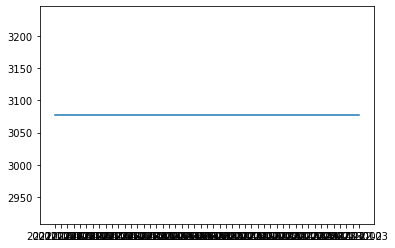

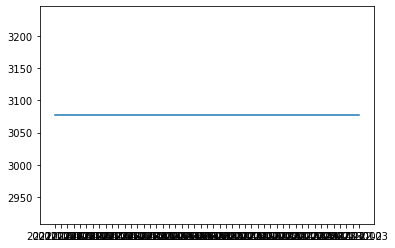

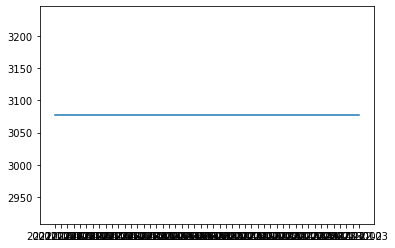

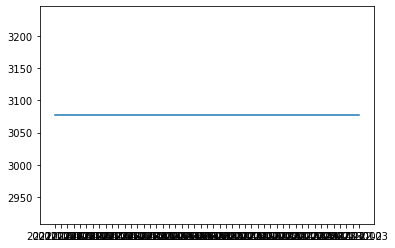

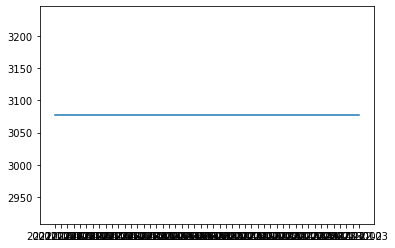

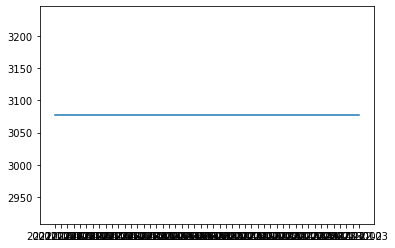

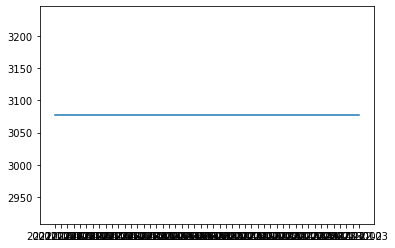

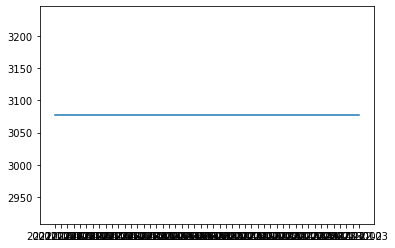

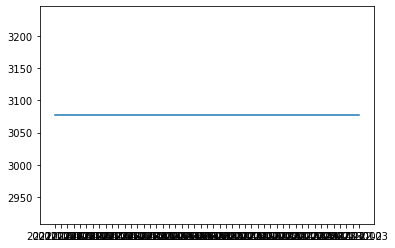

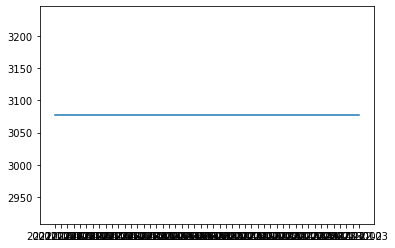

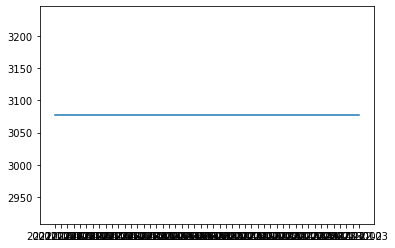

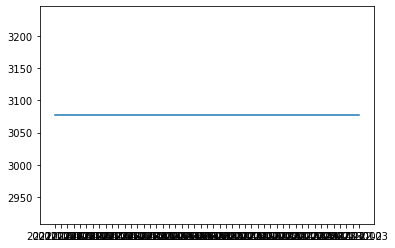

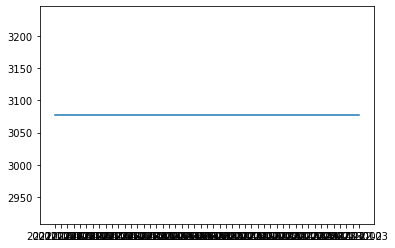

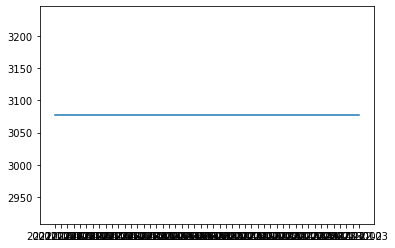

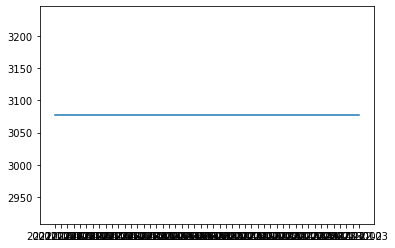

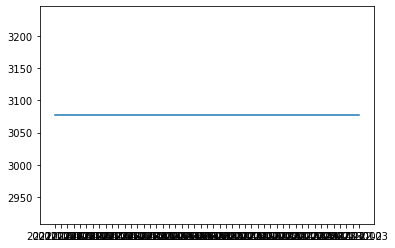

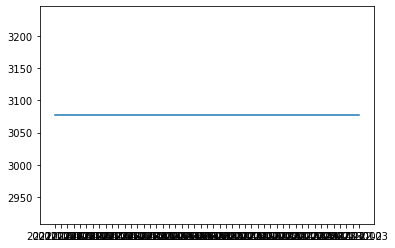

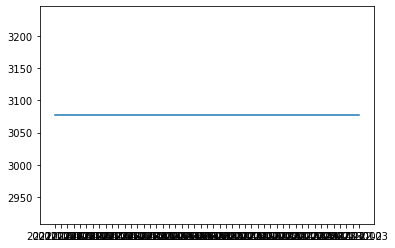

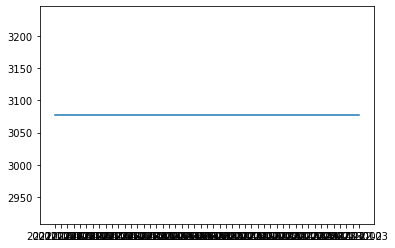

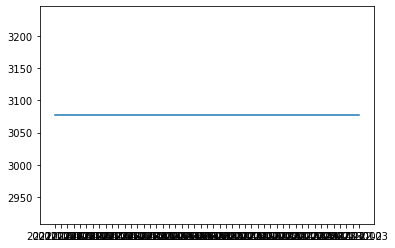

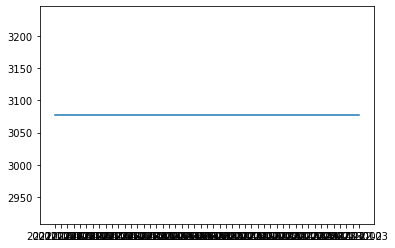

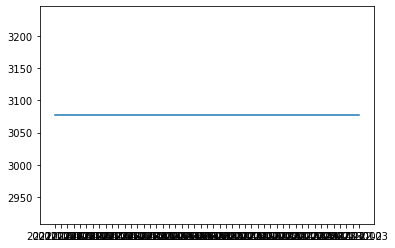

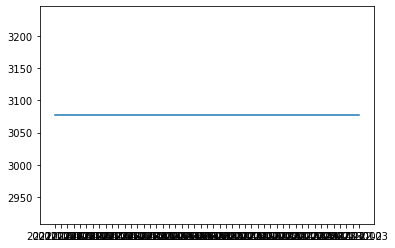

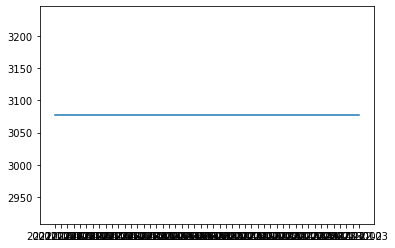

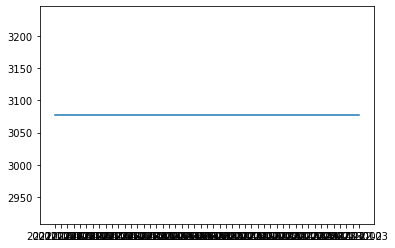

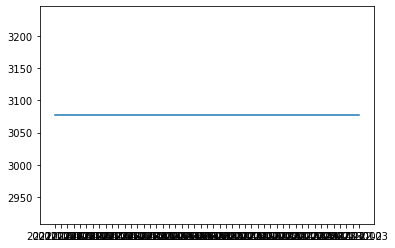

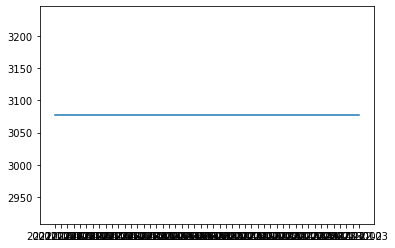

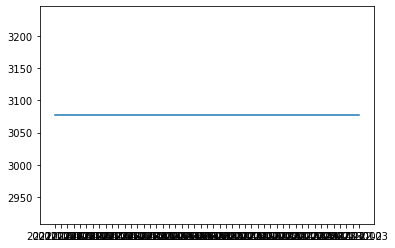

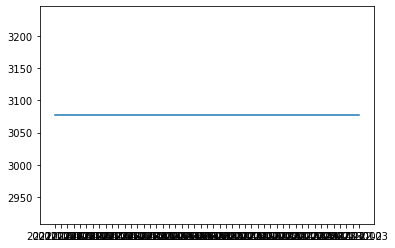

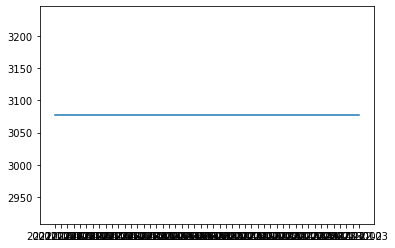

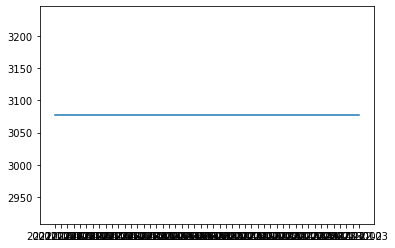

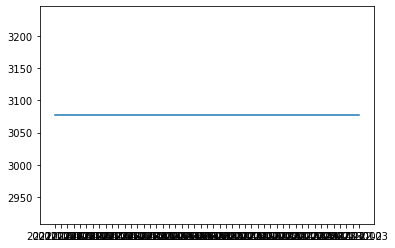

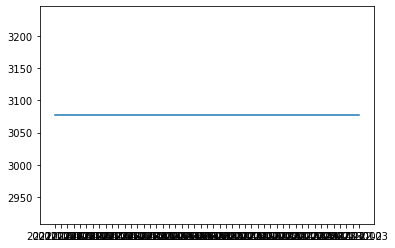

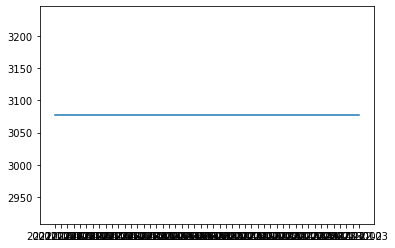

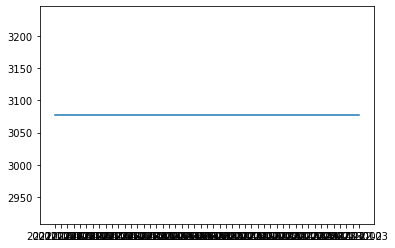

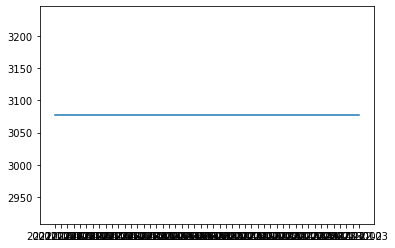

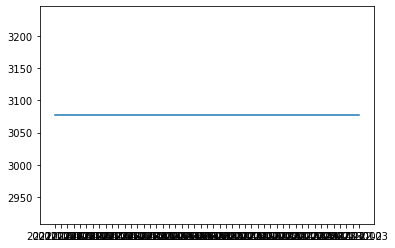

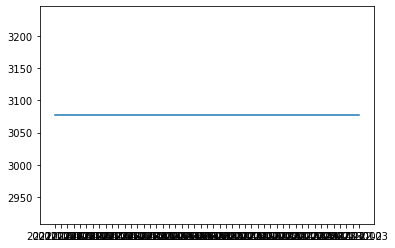

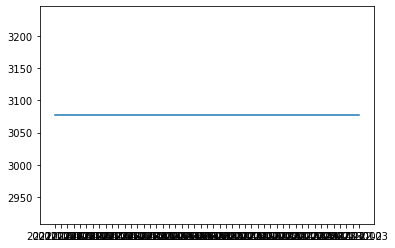

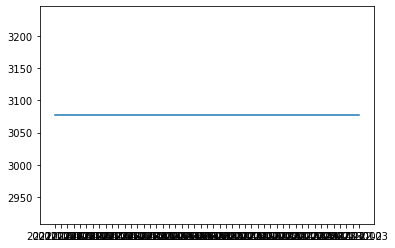

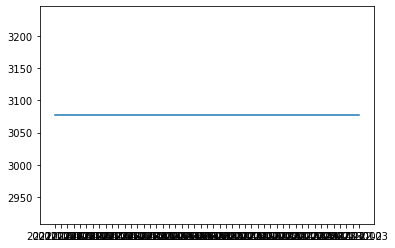

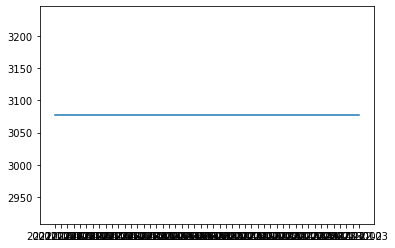

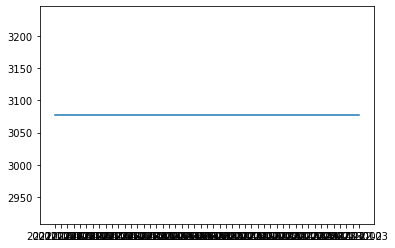

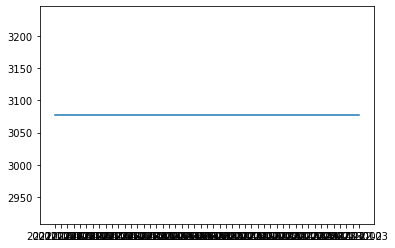

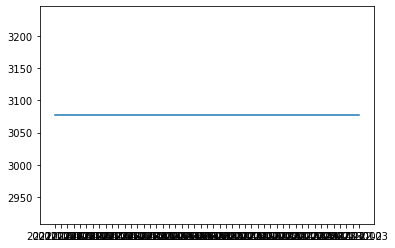

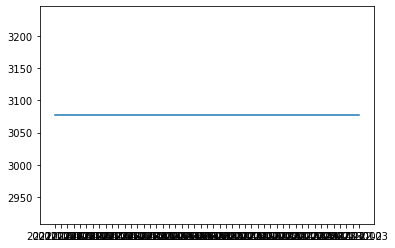

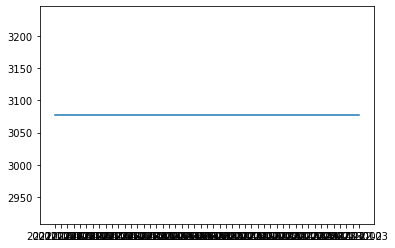

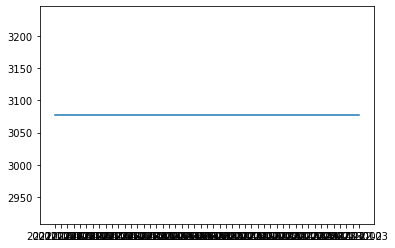

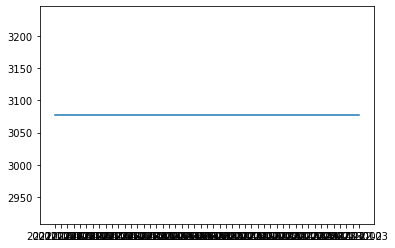

In [69]:
for state in state_list:
    plt.figure()
    plt.plot(res_df_gbm[res_df_gbm['subregion1_code']==state]['date'], res_df_gbm[res_df_gbm['subregion1_code']==state]['new_confirmed_pred'])